In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.spatial.distance import cdist
import matplotlib.ticker as mtick
import pickle

from src.metric import transfrom_label

# Useful functions

In [3]:
def z_matrixprofile(signal,wlen): 
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen): 
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX

def z_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    X = X-X_bar
    X = X/np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    sub = sub-np.mean(sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile

def lt_matrixprofile(signal,wlen):
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t,axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    A = cdist(X,X)
    for i in range(wlen):
        np.fill_diagonal(A[i:,:],np.inf)
        np.fill_diagonal(A[:,i:],np.inf)
    P = np.min(A,axis=1)
    IDX = np.argmin(A,axis = 1)
    return P,IDX
def lt_distanceprofile(signal,subsequence): 
    wlen = subsequence.shape[0]
    X =sliding_window_view(signal,wlen)
    X_bar = np.mean(X,axis=1).reshape(-1,1)
    t = np.arange(wlen)
    t_bar = np.mean(t)
    a = (np.sum(X*t.reshape(1,-1),axis=1).reshape(-1,1)/wlen - X_bar*t_bar)/np.std(t)**2
    b = X_bar - a*t_bar
    X = X- (a*t +b)
    X /= np.linalg.norm(X,axis=1).reshape(-1,1)
    sub = subsequence.copy()
    a_sub = (np.sum(sub*t)/wlen -t_bar*np.mean(sub))/np.std(t)**2
    b_sub = np.mean(sub) - a_sub * t_bar
    sub = sub - (a_sub * t + b_sub)
    sub = sub/np.linalg.norm(sub)
    sub = sub.reshape(1,-1)
    distance_profile = np.linalg.norm(X-sub,axis=1)
    return distance_profile


In [4]:
def _R_label(idx_lst: list,size:int,margin = 10):
    """_summary_

    Args:
        idx_lst (list): annotation
        size (int): final size of label
        margin (int, optional): margin in number of points. Defaults to 10.
    """
    label_mask = np.zeros(size)
    label_arr = []
    for idx in idx_lst: 
        start = max(0,idx-margin)
        end = min(size,idx+margin)
        rng = np.arange(start,end)
        label_mask[rng]=1
        label_arr.append([start,end])
    return label_mask.astype(int), np.array(label_arr)

def profile_score(r_idx_lst, profile,margin=10,n_threshold=201): 
    r_mask,r_arr = _R_label(r_idx_lst,profile.shape[0],margin)
    threshold = np.linspace(0,2,n_threshold)
    score = np.zeros((n_threshold,2))
    sort_idxs = np.argsort(profile)
    min_dist = profile[sort_idxs[0]]
    threshold_idx = np.where(min_dist<threshold)[0][0]

    starts = r_arr[:,0]
    ends = []
    if starts[0]!=0: 
        ends.append(0)
    ends += r_arr[:,1].tolist()
    if ends[-1] == r_mask.shape[0]: 
        ends.pop()
    ends = np.array(ends)

    n_tp = starts.shape[0]
    n_fp = ends.shape[0]
    tp_arr = np.zeros(n_tp)
    fp_arr = np.zeros(n_fp)
    count = [0,0]


    for idx in sort_idxs: 
        dist = profile[idx]
        if dist>threshold[threshold_idx]:
            next_threshold_idx = np.where(dist<threshold)[0][0]
            for i in np.arange(threshold_idx,next_threshold_idx): 
                score[i] = count
            threshold_idx = next_threshold_idx
            
        if r_mask[idx]==1: 
            l_idx = np.where(idx>=starts)[0][-1]
            if tp_arr[l_idx] == 0: 
                count[1]+=1/n_tp
                tp_arr[l_idx] =1 
        
        else: 
            l_idx = np.where(idx>=ends)[0][-1]
            if fp_arr[l_idx] == 0: 
                count[0]+=1/n_fp
                fp_arr[l_idx] = 1

    score[threshold_idx:,:] = count
    return score

In [5]:
def plot_signal_profil(signal,wlen,Pa,IDXa,Pz,IDXz,TrueIDX=None):
    idxa = np.argmin(Pa)
    idxz = np.argmin(Pz)
    fig,axs = plt.subplots(3,1,sharex=True,figsize = (10,5))

    if TrueIDX is not None: 
        for pos in TrueIDX:
            for i in range(3): 
                axs[i].axvspan(pos,pos+wlen,facecolor = "blue", alpha=0.1,label = "True position")

    axs[0].plot(signal, color = "black", alpha = 0.3)
    time = np.arange(idxa,idxa+wlen)
    axs[0].plot(time,signal[time],color = "tab:orange",label= "LT-Motif")
    idxa_bis = IDXa[idxa]
    time = np.arange(idxa_bis,idxa_bis+wlen)
    axs[0].plot(time,signal[time],color = "tab:orange")

    time = np.arange(idxz,idxz+wlen)
    axs[0].plot(time,signal[time],color = "tab:blue", label = "Z-Motif")
    idxz_bis = IDXz[idxz]
    time = np.arange(idxz_bis,idxz_bis+wlen)
    axs[0].plot(time,signal[time],color = "tab:blue")

    axs[1].plot(Pa, color = "black", alpha = 0.3)
    axs[1].scatter([idxa,idxa_bis],[Pa[idxa],Pa[idxa_bis]],100,color = "tab:orange", marker = "X",label = "LT-Start")

    axs[2].plot(Pz, color = "black",alpha = 0.3)
    axs[2].scatter([idxz,idxz_bis],[Pz[idxz],Pz[idxz_bis]],100,color = "tab:blue", marker = "X", label = "Z-Start")

    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_ylabel("Time series",fontsize=20)
    axs[1].set_yticks([])
    axs[1].set_ylabel("LT-profile",fontsize=20)
    axs[2].set_yticks([])
    axs[2].set_ylabel("Z-profile",fontsize=20)

    handles, labels = axs[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0].legend(by_label.values(), by_label.keys(),fontsize = 15)

    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend([handles[-1]],[labels[-1]],fontsize = 15)
    
    handles, labels = axs[2].get_legend_handles_labels()
    axs[2].legend([handles[-1]],[labels[-1]],fontsize = 15)

    axs[2].set_xlabel("time",fontsize=15)
    fig.tight_layout()
    return fig,axs

# Motif set discovery

In [6]:
EXP_PATH = "./experiment/"

mapping_distance = {
    'LTNormalizedEuclidean' : "LT-normalized",
    'NormalizedEuclidean' : "Z-normalized",
}

mapping_dataset = {
    "REFIT" : "refit",
    "single_fixed_synthetic" : "single",
    "fixed_synthetic" : "fixed",
    "synthetic" : "variable", 
    "mitdb" : "mitdb2", 
    "mitdb800" : "mitdb800",
    "arm-CODA" : "arm-coda",
    "mitdb1" : "mitdb1",
    "ptt-ppg" : "ptt-ppg"
}

order_dataset = ["single","fixed","variable","arm-coda","mitdb1","mitddb2","mitdb800","ptt-ppg","refit"]

METRICS = ["es-precision_0.5", "es-recall_0.5", "es-fscore_0.5"]

mapping_metric = {
    "es-precision_0.5" : "precision", 
    "es-recall_0.5" : "recall", 
    "es-fscore_0.5" : "fscore"
}

cmap = plt.cm.tab10
folder = "lt-normalized"
path = EXP_PATH + "results/"
lst = []
for f in [f for f in os.listdir(path) if "_0.csv" in f]: 
    df = pd.read_csv(path + f,index_col=0)
    df = df[df["metric"].isin(METRICS)]
    df["metric"] = df["metric"].apply(lambda x : mapping_metric[x])
    df["algorithm"] = df.apply(lambda row : "LT-nomarlized" if row["config_idx"]==0 else "Z-normalized",axis=1)
    df = df[["metric","algorithm","score"]]
    df = df.groupby(["metric","algorithm"]).mean().reset_index()
    name = f.removesuffix("_MatrixProfile_0.csv")
    df["dataset"] = mapping_dataset[name]
    lst.append(df)
df = pd.concat(lst)
df = df[df["dataset"].isin(["single","fixed","arm-coda","mitdb1","mitdb2", "ptt-ppg"])]

order_dataset = ["single","fixed","arm-coda","mitdb1","mitdb2", "ptt-ppg"]
df = pd.pivot_table(df,values="score",index=["dataset", "metric"],columns=["algorithm"],aggfunc="first")
df = df.loc[order_dataset]
# apply some formatting for all numbers (optional)
df_s = df.style.format("{:.2f}")

# loop through rows and find which column for each row has the highest value
for row in df.index:
    col = df.loc[row].idxmax()
    # redo formatting for a specific cell
    df_s = df_s.format(lambda x: "\\textbf{" + f'{x:.2f}' + "}", subset=(row, col))
print(df_s.to_latex(hrules = True, clines = "skip-last;data",multirow_align = "t"))


\begin{tabular}{llrr}
\toprule
 & algorithm & LT-nomarlized & Z-normalized \\
dataset & metric &  &  \\
\midrule
\multirow[t]{3}{*}{single} & fscore & \textbf{0.83} & 0.69 \\
 & precision & \textbf{1.00} & 0.98 \\
 & recall & \textbf{0.72} & 0.54 \\
\cline{1-4}
\multirow[t]{3}{*}{fixed} & fscore & \textbf{0.59} & 0.57 \\
 & precision & \textbf{0.54} & 0.53 \\
 & recall & \textbf{0.68} & 0.67 \\
\cline{1-4}
\multirow[t]{3}{*}{arm-coda} & fscore & \textbf{0.22} & 0.19 \\
 & precision & \textbf{0.19} & 0.17 \\
 & recall & \textbf{0.35} & 0.33 \\
\cline{1-4}
\multirow[t]{3}{*}{mitdb1} & fscore & \textbf{0.57} & 0.53 \\
 & precision & \textbf{0.98} & 0.97 \\
 & recall & \textbf{0.42} & 0.39 \\
\cline{1-4}
\multirow[t]{3}{*}{mitdb2} & fscore & \textbf{0.43} & 0.39 \\
 & precision & \textbf{0.73} & 0.72 \\
 & recall & \textbf{0.36} & 0.32 \\
\cline{1-4}
\multirow[t]{3}{*}{ptt-ppg} & fscore & \textbf{0.54} & 0.47 \\
 & precision & 0.97 & \textbf{0.98} \\
 & recall & \textbf{0.39} & 0.33 \\
\cl

# Scalability

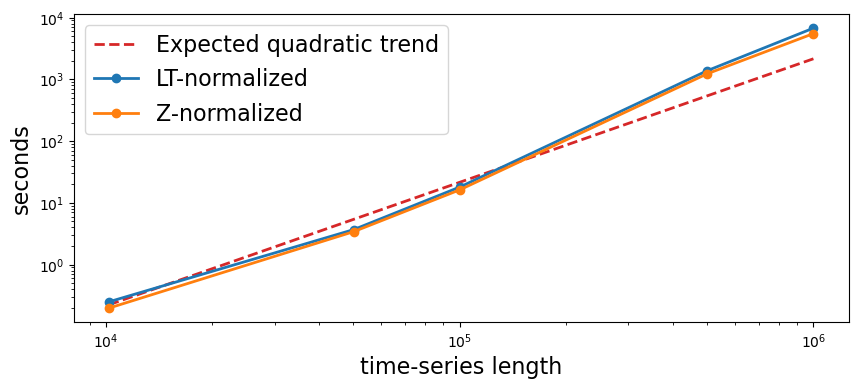

In [7]:
df = pd.read_csv("./experiment/results/scalability.csv",index_col=0).reset_index(drop=True)
df = df[["distance","tslen","duration"]]
df["distance"] = df["distance"].apply(lambda x : mapping_distance[x])
df = df.groupby(["distance","tslen"]).mean().reset_index()
df2 = pd.pivot_table(df,values="duration", index="distance", columns="tslen",aggfunc="first")
names = df2.index
x = df2.columns.to_numpy()
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(x,np.mean(df2.values[:,0])*(x/x[0])**2, "--",color="tab:red",linewidth=2,label ="Expected quadratic trend")
for y,name in zip(df2.values,names): 
    ax.plot(x,y,"-o",label = name,linewidth=2)
ax.set_yscale("log")
ax.set_xlabel("time-series length",fontsize=16)
ax.set_ylabel("seconds",fontsize=16)
ax.set_xscale("log")
ax.legend(fontsize=16)

# Similarity search
## ECG Experiment

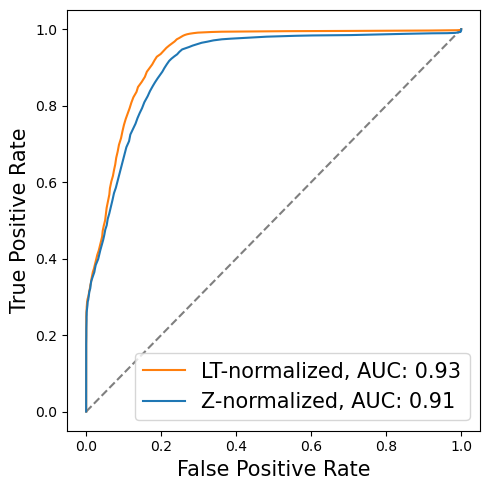

In [4]:
with open("dataset/mitdb1/labels.pkl", "rb") as f: 
    labels = pickle.load(f)

labels = [transfrom_label(x)[0] for x in labels]

with open("dataset/mitdb1/dataset.pkl", "rb") as f: 
    dataset = pickle.load(f)

dataset = dataset

wlen = 20000
z_score = []
lt_score = []
s_counts = 0
for signal,label in zip(dataset,labels):
    r_idx_lst = label[:,0]
    subsequence = signal[label[1][0]:label[1][1]]
    r_idx_lst = r_idx_lst[r_idx_lst<=wlen-subsequence.shape[0]+1]
    z_profile = z_distanceprofile(signal,subsequence)
    t_z_score = profile_score(r_idx_lst,z_profile,margin=40,n_threshold=201)
    z_score.append(t_z_score)
    lt_profile = lt_distanceprofile(signal,subsequence)
    t_lt_score = profile_score(r_idx_lst,lt_profile,margin=40,n_threshold=201)
    lt_score.append(t_lt_score)  

ecg_lt_score = np.mean(np.array(lt_score),axis=0)
ecg_z_score = np.mean(np.array(z_score),axis=0)   

lt_fpr,lt_tpr = np.unique(ecg_lt_score,axis=0).T
ecg_auc_lt = np.sum(np.diff(lt_fpr)*lt_tpr[1:])

z_fpr,z_tpr = np.unique(ecg_z_score,axis=0).T
ecg_auc_z = np.sum(np.diff(z_fpr)*z_tpr[1:])

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
plt.plot(*np.unique(ecg_lt_score,axis=0).T,label = f"LT-normalized, AUC: {np.round(ecg_auc_lt,2)}", color = "tab:orange")
plt.plot(*np.unique(ecg_z_score,axis=0).T, label = f"Z-normalized, AUC: {np.round(ecg_auc_z,2)}", color = "tab:blue")
ax.set_xlabel("False Positive Rate",fontsize =15)
ax.set_ylabel("True Positive Rate",fontsize =15)
ax.legend(fontsize =15)
fig.tight_layout()

## PPG Experiment

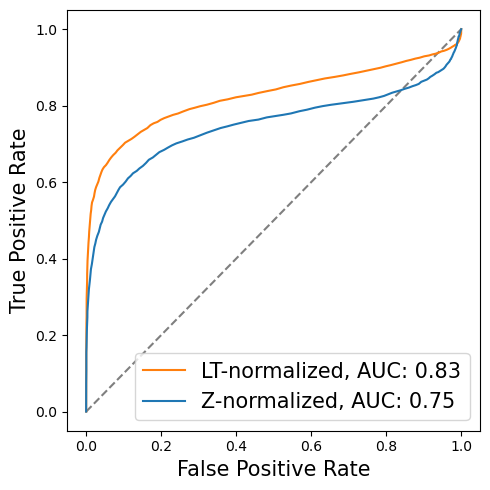

In [6]:
with open("dataset/ptt-ppg/labels.pkl", "rb") as f: 
    labels = pickle.load(f)

labels = [transfrom_label(x)[0] for x in labels]

with open("dataset/ptt-ppg/dataset.pkl", "rb") as f: 
    dataset = pickle.load(f)

ppg_dataset = dataset.copy()
ppg_subsequences = []

wlen = 20000
z_score = []
lt_score = []
s_counts = 0
for signal,label in zip(dataset,labels):
    r_idx_lst = label[:,0]
    subsequence = signal[label[1][0]:label[1][1]]
    ppg_subsequences.append(subsequence)
    r_idx_lst = r_idx_lst[r_idx_lst<=wlen-subsequence.shape[0]+1]
    z_profile = z_distanceprofile(signal,subsequence)
    t_z_score = profile_score(r_idx_lst,z_profile,margin=40,n_threshold=201)
    z_score.append(t_z_score)
    lt_profile = lt_distanceprofile(signal,subsequence)
    t_lt_score = profile_score(r_idx_lst,lt_profile,margin=40,n_threshold=201)
    lt_score.append(t_lt_score)  

ppg_lt_copy = lt_score.copy()
ppg_lt_score = np.mean(np.array(lt_score),axis=0)
ppg_z_copy = z_score.copy()
ppg_z_score = np.mean(np.array(z_score),axis=0)  

lt_fpr,lt_tpr = np.unique(ppg_lt_score,axis=0).T
ppg_auc_lt = np.sum(np.diff(lt_fpr)*lt_tpr[1:])

z_fpr,z_tpr = np.unique(ppg_z_score,axis=0).T
ppg_auc_z = np.sum(np.diff(z_fpr)*z_tpr[1:])

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
plt.plot(*np.unique(ppg_lt_score,axis=0).T,label = f"LT-normalized, AUC: {np.round(ppg_auc_lt,2)}", color = "tab:orange")
plt.plot(*np.unique(ppg_z_score,axis=0).T, label = f"Z-normalized, AUC: {np.round(ppg_auc_z,2)}", color = "tab:blue")
ax.set_xlabel("False Positive Rate",fontsize =15)
ax.set_ylabel("True Positive Rate",fontsize =15)
ax.legend(fontsize =15)
fig.tight_layout()

## Single fixed synthetic

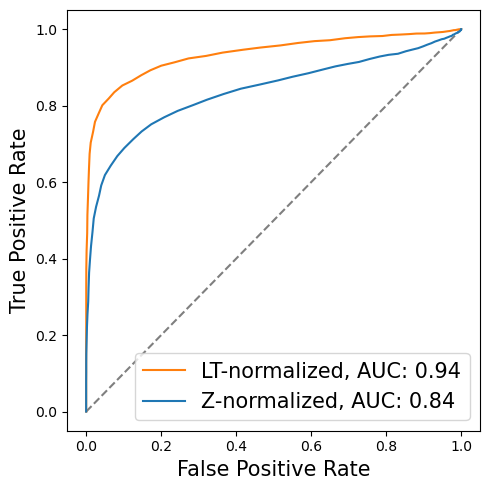

In [9]:
with open("dataset/single_fixed_synthetic/labels.pkl", "rb") as f: 
    labels = pickle.load(f)

labels = [transfrom_label(x)[0] for x in labels]

with open("dataset/single_fixed_synthetic/dataset.pkl", "rb") as f: 
    dataset = pickle.load(f)

dataset = dataset

wlen = 20000
z_score = []
lt_score = []
s_counts = 0
for signal,label in zip(dataset,labels):
    r_idx_lst = label[:,0]
    subsequence = signal[label[1][0]:label[1][1]]
    r_idx_lst = r_idx_lst[r_idx_lst<=wlen-subsequence.shape[0]+1]
    z_profile = z_distanceprofile(signal,subsequence)
    t_z_score = profile_score(r_idx_lst,z_profile,margin=2,n_threshold=201)
    z_score.append(t_z_score)
    lt_profile = lt_distanceprofile(signal,subsequence)
    t_lt_score = profile_score(r_idx_lst,lt_profile,margin=2,n_threshold=201)
    lt_score.append(t_lt_score)  

s_lt_score = np.mean(np.array(lt_score),axis=0)
s_z_score = np.mean(np.array(z_score),axis=0)   

lt_fpr,lt_tpr = np.unique(s_lt_score,axis=0).T
s_auc_lt = np.sum(np.diff(lt_fpr)*lt_tpr[1:])

z_fpr,z_tpr = np.unique(s_z_score,axis=0).T
s_auc_z = np.sum(np.diff(z_fpr)*z_tpr[1:])

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
plt.plot(*np.unique(s_lt_score,axis=0).T,label = f"LT-normalized, AUC: {np.round(s_auc_lt,2)}", color = "tab:orange")
plt.plot(*np.unique(s_z_score,axis=0).T, label = f"Z-normalized, AUC: {np.round(s_auc_z,2)}", color = "tab:blue")
ax.set_xlabel("False Positive Rate",fontsize =15)
ax.set_ylabel("True Positive Rate",fontsize =15)
ax.legend(fontsize =15)
fig.tight_layout()

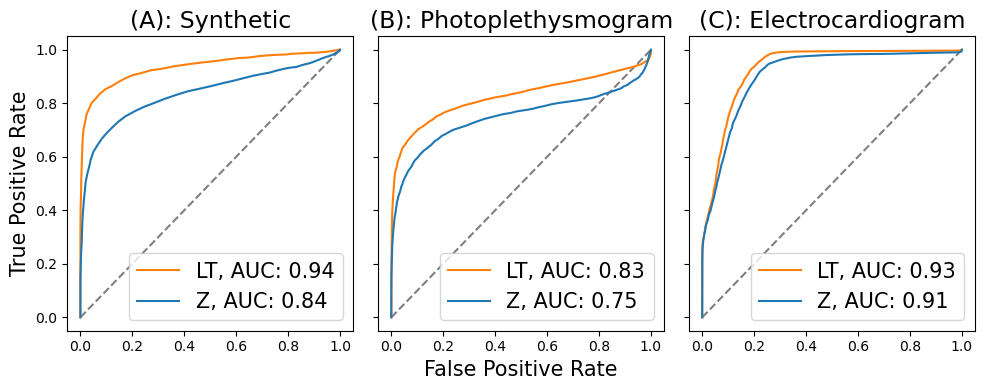

In [10]:
fig,axs = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)

axs[0].plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
axs[0].plot(*np.unique(s_lt_score,axis=0).T,label = f"LT, AUC: {np.round(s_auc_lt,2)}", color = "tab:orange")
axs[0].plot(*np.unique(s_z_score,axis=0).T, label = f"Z, AUC: {np.round(s_auc_z,2)}", color = "tab:blue")
axs[0].set_ylabel("True Positive Rate",fontsize =15)
axs[0].legend(fontsize=15,loc=4)
axs[0].set_title("(A): Synthetic", fontsize=17)

axs[1].plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
axs[1].plot(*np.unique(ppg_lt_score,axis=0).T,label = f"LT, AUC: {np.round(ppg_auc_lt,2)}", color = "tab:orange")
axs[1].plot(*np.unique(ppg_z_score,axis=0).T, label = f"Z, AUC: {np.round(ppg_auc_z,2)}", color = "tab:blue")
axs[1].set_xlabel("False Positive Rate",fontsize =15)
axs[1].legend(fontsize=15,loc=4)
axs[1].set_title("(B): Photoplethysmogram", fontsize=17)


axs[2].plot(np.linspace(0,1,100),np.linspace(0,1,100),color="black", alpha=0.5,linestyle = "dashed")
axs[2].plot(*np.unique(ecg_lt_score,axis=0).T,label = f"LT, AUC: {np.round(ecg_auc_lt,2)}", color = "tab:orange")
axs[2].plot(*np.unique(ecg_z_score,axis=0).T, label = f"Z, AUC: {np.round(ecg_auc_z,2)}", color = "tab:blue")
axs[2].legend(fontsize=15,loc=4)
axs[2].set_title("(C): Electrocardiogram", fontsize=17)
fig.tight_layout()


# Best Motif Pair

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: ylabel='Time series'>, <Axes: ylabel='LT-profile'>,
        <Axes: xlabel='time', ylabel='Z-profile'>], dtype=object))

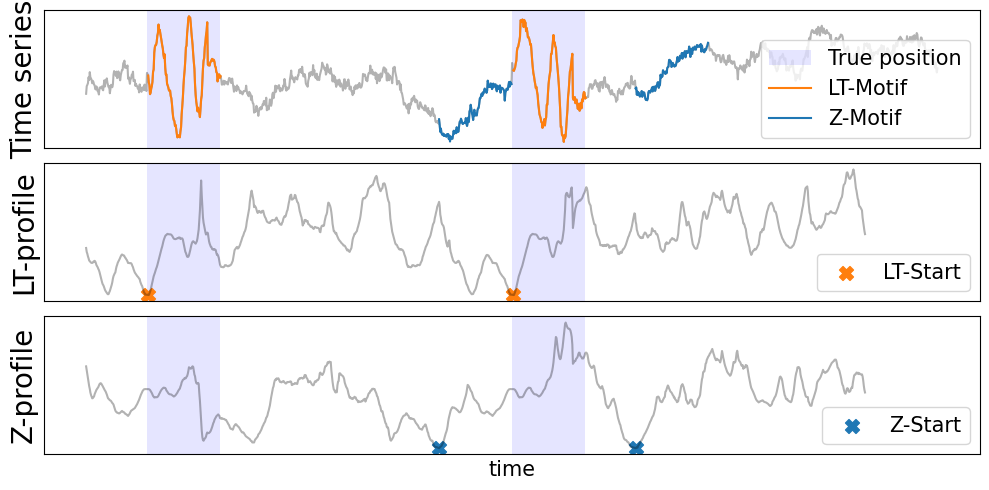

In [12]:
from src.synthetic_signal import SignalGenerator
from src.metric import EventScore

WLEN = 120
M_WLEN =100
N_SIGNALS = 100
np.random.seed(9)
sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=5,min_rep=2,max_rep=2,walk_amplitude=0.3,noise_amplitude=0.2)
sg.generate()
signal = sg.signal_

Pz,IDXz= z_matrixprofile(signal,WLEN)
Pa,IDXa = lt_matrixprofile(signal,WLEN)

plot_signal_profil(signal,WLEN,Pa,IDXa,Pz,IDXz,list(zip(*sg.positions_[0]))[0])

In [13]:
LMBDS = np.linspace(0,0.5,51)
WLEN = 120
M_WLEN =100
N_SIGNALS = 200
THESHOLD_RATIO = 0.5

def get_prediction(P,IDX,wlen): 
    idx1 = np.argmin(P)
    idx2 = IDX[idx1]
    if idx1< idx2:
        return [[idx1,idx1+wlen],[idx2,idx2+wlen]]
    else:
        return [[idx2,idx2+wlen],[idx1,idx1+wlen]]
    
def unit_score(R,P,threshold): 
    count = 0
    for (rs,re), (ps,pe) in zip(R,P):
        s = max(rs,ps)
        e = min(re,pe)
        if e-s >= threshold *(re-rs): 
            count +=1
    if count ==2: 
        return 1
    else: 
        return 0 


final_score =[]

for lmbd in LMBDS: 

    #generate dataset
    dataset = []
    labels = []
    sg = SignalGenerator(1,M_WLEN,1,4,"Sin",sparsity=10,min_rep=2,max_rep=2,walk_amplitude=lmbd,noise_amplitude=0.1)
    for i in range(N_SIGNALS): 
        signal, label = sg.generate()
        dataset.append(signal)
        rss = list(zip(*sg.positions_[0]))[0]
        label = []
        for rs in rss: 
            label.append([rs,rs+M_WLEN])
        labels.append(label)

    #get score
    ses = EventScore()
    threshold_score = []
    for method in [z_matrixprofile,lt_matrixprofile]:
        t_scores = []
        for signal,label in zip(dataset,labels): 
            P,IDX = method(signal,WLEN)
            L = signal.shape[0]
            pred = get_prediction(P,IDX,WLEN)
            
            t_scores.append(unit_score(label,pred,THESHOLD_RATIO))
        threshold_score.append(np.mean(t_scores,axis=0))
    final_score.append(threshold_score)

final_score = np.array(final_score)
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(LMBDS,final_score[:,0],label = "Z-normalized", color = "tab:blue")
ax.plot(LMBDS,final_score[:,1],label = "LT-normalized", color = "tab:orange")
ax.set_xlabel("Random walk variance",fontsize=15)
ax.set_ylabel("Accuracy score",fontsize=15)
ax.legend(fontsize=15)
ax.set_ylim(-0.05,1.05)
fig.tight_layout()